<a href="https://colab.research.google.com/github/BeastHunter0041/csci_4170_s26/blob/main/hw3_CSCI4170.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1
##Neural Network From Scratch (Regression Version)

Goal:
Predict **Number Captured** using a fully-connected neural network built from scratch.

This implementation of a neural network includes includes:
1. Data loading and preprocessing
2. Train/test split
3. Custom NeuralNetwork class
4. Training with mini-batch gradient descent
5. Evaluation (MSE and R²)


In [2]:
import numpy as np
import pandas as pd

DATA_PATH = "/content/First_10100_GL_FishBiodiversity.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (10100, 93)


,Project Name,Field Number,Date,Day,Month,Year,Date fished,Waterbody Name,WaterbodyType,Arrival Time,...,Stream depth (m),depth_>_recorded,Water velocity (msec),Bin Number,Bin_time_s,Species,Number Captured,Caught > Number captured,Minimum (mm),Maximum (mm)
0,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Micropterus nigricans,2.0,False,0.00,0.00
1,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Lepomis peltastes,3.0,False,39.40,44.94
2,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Notemigonus crysoleucas,2.0,False,32.60,68.70
3,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Umbra limi,2.0,False,50.39,50.39
4,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Notropis heterolepis,5.0,False,22.89,46.10


## Preprocessing Strategy

- Target variable: **Number Captured**
- Convert time columns to numeric minutes
- One-hot encode small categorical columns
- Standardize features (important for neural networks)
- Drop rows with missing target


In [3]:
TARGET = "Number Captured"

data = df.dropna(subset=[TARGET]).copy()

numeric_cols = [
    "Day", "Month", "Year",
    "Start Latitude", "Start Longitude",
    "Stop Latitude", "Stop Longitude"
]

cat_cols = ["WaterbodyType", "Gear"]
time_cols = ["Start Time", "Stop Time", "Arrival Time", "Departure Time"]

use_cols = [c for c in numeric_cols + cat_cols + time_cols + [TARGET] if c in data.columns]
data = data[use_cols].copy()

def time_to_minutes(series):
    t = pd.to_datetime(series, errors="coerce")
    return t.dt.hour * 60 + t.dt.minute

for c in time_cols:
    if c in data.columns:
        data[c + "_min"] = time_to_minutes(data[c])

if "Start Time_min" in data.columns and "Stop Time_min" in data.columns:
    data["FishingDuration_min"] = data["Stop Time_min"] - data["Start Time_min"]

data = data.drop(columns=[c for c in time_cols if c in data.columns])

cat_present = [c for c in cat_cols if c in data.columns]
data = pd.get_dummies(data, columns=cat_present, dummy_na=True)

# X
X = data.drop(columns=[TARGET]).copy()
X = X.fillna(0)

X_np = X.to_numpy(dtype=np.float64)
X_mu = X_np.mean(axis=0, keepdims=True)
X_sigma = X_np.std(axis=0, keepdims=True) + 1e-8
X_np = (X_np - X_mu) / X_sigma

# y (log transform + standardize)
y_raw = data[TARGET].astype(np.float64).to_numpy().reshape(-1, 1)
y_log = np.log1p(y_raw)  # handles skew + huge counts safely

y_mu = y_log.mean(axis=0, keepdims=True)
y_sigma = y_log.std(axis=0, keepdims=True) + 1e-8
y = (y_log - y_mu) / y_sigma

def y_inverse_transform(y_pred_std):
    """
    Convert standardized log-space predictions back to original 'Number captured' scale.
    """
    y_pred_log = y_pred_std * y_sigma + y_mu
    return np.expm1(y_pred_log)

print("X shape:", X_np.shape)
print("y shape:", y.shape)
print("Raw y range:", float(y_raw.min()), "to", float(y_raw.max()))


X shape: (9882, 30)
y shape: (9882, 1)
Raw y range: 0.0 to 2000.0


/tmp/ipython-input-1665434965.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(series, errors="coerce")
/tmp/ipython-input-1665434965.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(series, errors="coerce")


In [4]:
def train_test_split_numpy(X, Y, test_size=0.2, seed=42):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = np.arange(n)
    rng.shuffle(idx)
    test_n = int(n * test_size)
    test_idx = idx[:test_n]
    train_idx = idx[test_n:]
    return X[train_idx], X[test_idx], Y[train_idx], Y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_numpy(
    X_np, y, test_size=0.2, seed=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (7906, 30)
Test: (1976, 30)


## Neural Network Architecture

- Fully connected layers
- ReLU activation (hidden layers)
- Linear output layer (regression)
- Loss function: Mean Squared Error (MSE)
- Optimization: Mini-batch Gradient Descent


In [5]:
class NeuralNetwork:
    def __init__(
        self,
        layer_dims,
        learning_rate=0.001,
        epochs=300,
        batch_size=128,
        seed=42,
        print_every=25,
        clip_value=1.0
    ):
        self.layer_dims = layer_dims
        self.learning_rate = float(learning_rate)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size) if batch_size is not None else None
        self.rng = np.random.default_rng(seed)
        self.print_every = int(print_every)
        self.clip_value = float(clip_value)
        self.params = self._init_params()

    def _init_params(self):
        params = {}
        L = len(self.layer_dims) - 1
        for l in range(1, L + 1):
            fan_in = self.layer_dims[l - 1]
            fan_out = self.layer_dims[l]
            W = self.rng.normal(0, np.sqrt(2.0 / fan_in), size=(fan_in, fan_out))
            b = np.zeros((1, fan_out))
            params[f"W{l}"] = W
            params[f"b{l}"] = b

        # smaller output layer weights for stability
        params[f"W{L}"] *= 0.1
        return params

    @staticmethod
    def _relu(Z):
        return np.maximum(0.0, Z)

    @staticmethod
    def _relu_backward(dA, Z):
        dZ = dA.copy()
        dZ[Z <= 0.0] = 0.0
        return dZ

    def forward(self, X):
        """
        Returns:
          preds: (N, 1)
          caches: list of dicts with A_prev, W, b, Z for each layer
        """
        A = X
        caches = []
        L = len(self.layer_dims) - 1

        # Hidden layers
        for l in range(1, L):
            W = self.params[f"W{l}"]
            b = self.params[f"b{l}"]
            A_prev = A
            Z = A_prev @ W + b
            A = self._relu(Z)
            caches.append({"A_prev": A_prev, "W": W, "b": b, "Z": Z})

        # Output layer (linear)
        W = self.params[f"W{L}"]
        b = self.params[f"b{L}"]
        A_prev = A
        ZL = A_prev @ W + b
        caches.append({"A_prev": A_prev, "W": W, "b": b, "Z": ZL})

        return ZL, caches

    @staticmethod
    def cost(preds, Y):
        diff = preds - Y
        return float(np.mean(diff * diff))

    def backward(self, preds, Y, caches):
        grads = {}
        N = Y.shape[0]
        L = len(self.layer_dims) - 1

        # Output layer: MSE derivative
        dZ = (2.0 / N) * (preds - Y)  # (N, 1)
        out = caches[-1]
        A_prev = out["A_prev"]
        W = out["W"]

        grads[f"dW{L}"] = A_prev.T @ dZ
        grads[f"db{L}"] = np.sum(dZ, axis=0, keepdims=True)
        dA_prev = dZ @ W.T

        # Hidden layers
        for l in range(L - 1, 0, -1):
            cache = caches[l - 1]
            A_prev = cache["A_prev"]
            W = cache["W"]
            Z = cache["Z"]

            dZ = self._relu_backward(dA_prev, Z)
            grads[f"dW{l}"] = A_prev.T @ dZ
            grads[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True)
            dA_prev = dZ @ W.T

        # Gradient clipping
        if self.clip_value is not None and self.clip_value > 0:
            for k in grads:
                np.clip(grads[k], -self.clip_value, self.clip_value, out=grads[k])

        return grads

    def _update_params(self, grads):
        L = len(self.layer_dims) - 1
        for l in range(1, L + 1):
            self.params[f"W{l}"] -= self.learning_rate * grads[f"dW{l}"]
            self.params[f"b{l}"] -= self.learning_rate * grads[f"db{l}"]

    def _iterate_minibatches(self, X, Y):
        N = X.shape[0]
        idx = np.arange(N)
        self.rng.shuffle(idx)
        Xs, Ys = X[idx], Y[idx]

        if self.batch_size is None:
            yield Xs, Ys
            return

        for start in range(0, N, self.batch_size):
            end = min(start + self.batch_size, N)
            yield Xs[start:end], Ys[start:end]

    def train(self, X, Y):
        for epoch in range(1, self.epochs + 1):
            losses = []
            for Xb, Yb in self._iterate_minibatches(X, Y):
                preds, caches = self.forward(Xb)

                if not np.isfinite(preds).all():
                    raise FloatingPointError("Predictions became NaN/Inf. Reduce LR or increase clipping.")

                loss = self.cost(preds, Yb)
                if not np.isfinite(loss):
                    raise FloatingPointError("Loss became NaN/Inf. Reduce LR or transform target.")

                grads = self.backward(preds, Yb, caches)
                self._update_params(grads)
                losses.append(loss)

            if epoch % self.print_every == 0 or epoch == 1:
                print(f"Epoch {epoch}/{self.epochs} | MSE: {np.mean(losses):.6f}")

    def predict(self, X):
        preds, _ = self.forward(X)
        return preds


In [6]:
D = X_train.shape[1]

nn = NeuralNetwork(
    layer_dims=[D, 64, 32, 1],
    learning_rate=0.001,
    epochs=300,
    batch_size=128,
    clip_value=1.0,
    print_every=25
)

nn.train(X_train, y_train)


Epoch 1/300 | MSE: 1.020958
Epoch 25/300 | MSE: 0.961700
Epoch 50/300 | MSE: 0.942978
Epoch 75/300 | MSE: 0.933704
Epoch 100/300 | MSE: 0.927521
Epoch 125/300 | MSE: 0.921191
Epoch 150/300 | MSE: 0.916408
Epoch 175/300 | MSE: 0.914859
Epoch 200/300 | MSE: 0.911537
Epoch 225/300 | MSE: 0.909935
Epoch 250/300 | MSE: 0.908422
Epoch 275/300 | MSE: 0.907145
Epoch 300/300 | MSE: 0.905059


In [7]:
preds_train_std = nn.predict(X_train)
preds_test_std  = nn.predict(X_test)

# Metrics in standardized-log space
train_mse_std = np.mean((preds_train_std - y_train) ** 2)
test_mse_std  = np.mean((preds_test_std - y_test) ** 2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

print("Standardized-log space:")
print("Train MSE:", train_mse_std)
print("Test MSE: ", test_mse_std)
print("Train R²:", r2_score(y_train, preds_train_std))
print("Test R²: ", r2_score(y_test, preds_test_std))

# Convert predictions back to original scale
preds_train = y_inverse_transform(preds_train_std)
preds_test  = y_inverse_transform(preds_test_std)

y_train_raw = y_inverse_transform(y_train)
y_test_raw  = y_inverse_transform(y_test)

train_mse_raw = np.mean((preds_train - y_train_raw) ** 2)
test_mse_raw  = np.mean((preds_test - y_test_raw) ** 2)

print("\nOriginal target space (Number captured):")
print("Train MSE:", train_mse_raw)
print("Test MSE: ", test_mse_raw)
print("Train R²:", r2_score(y_train_raw, preds_train))
print("Test R²: ", r2_score(y_test_raw, preds_test))


Standardized-log space:
Train MSE: 0.9041127572470533
Test MSE:  0.8924624655942383
Train R²: 0.10647310585284087
Test R²:  0.06271221141960182

Original target space (Number captured):
Train MSE: 8504.997019676004
Test MSE:  1691.218985305651
Train R²: -0.005177487754313814
Test R²:  -0.016277237487483998


## Why Mini-Batch Gradient Descent?

Full-batch:
- Stable but slow for large datasets.

Stochastic:
- Very noisy updates.

Mini-batch:
- Efficient and stable.
- Good tradeoff between runtime and convergence.
- Works well in NumPy implementation.

For this dataset, mini-batch significantly improves runtime compared to full-batch training.


## Model Debugging + Performance Summary

### What Went Wrong Initially
- Target (Number captured) had large, skewed values --> exploding gradients --> NaN loss.
- Learning rate was too high for regression.
- Forward pass cached the wrong tensor (stored post-activation instead of A_prev) --> gradient shape mismatch --> broadcasting error.

### Fixes Applied
- I Applied log1p() transform + standardization to target.
- Reduced learning rate (0.01 → 0.001).
- I Added gradient clipping.
- Corrected cache storage in forward pass.
- Scaled down output layer initialization.

---

## Model Performance Analysis

### Standardized-Log Space
- Train MSE ≈ 0.90  
- Test MSE ≈ 0.89  
- Train R² ≈ 0.11  
- Test R² ≈ 0.06  

Interpretation:
- Model is stable (no NaNs).
- Small gap between train/test → no major overfitting.
- Low R² indicates weak predictive signal in current feature set.

### Original Target Space
- Train MSE ≈ 8505  
- Test MSE ≈ 1691  
- Train R² ≈ -0.005  
- Test R² ≈ -0.016  

Interpretation:
- Negative R² --> model performs roughly the same (or slightly worse) than predicting the mean.
- Neural network is not extracting strong nonlinear structure.
- Likely causes:
  - Weak feature-target relationship.
  - High noise in capture counts.
  - Count data may require Poisson-style modeling instead of MSE regression.

---

### Overall Conclusion
The model now trains correctly and generalizes consistently, but predictive power is low. Performance suggests either limited signal in the selected features or that a different modeling approach (e.g., Poisson regression, feature engineering, or interaction terms) may be more appropriate.


#Part 2

## Task 1 — PyTorch Resources Used (2-Layer Neural Network)

Below are the PyTorch-only resources I used to learn the framework components needed to implement a 2-layer neural network and the required components for this homework.

### 1) Defining the model + forward propagation (layers + forward())

- **PyTorch Tutorial: “Build the Neural Network”**  
  https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html  
  **Why I needed it:** Shows how to create a model using torch.nn.Module, define layers like nn.Linear, and implement the forward() method. This directly maps to building a 2-layer NN and running the forward pass.



### 2) Backward propagation via automatic differentiation (autograd)

- **PyTorch Tutorial: “Autograd: Automatic Differentiation”**  
  https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html  
  **Why I needed it:** Explains how PyTorch builds a computation graph during the forward pass and computes gradients using loss.backward(). This replaces manual backprop from Part 1.

- **API Reference: torch.autograd.backward**  
  https://pytorch.org/docs/stable/generated/torch.autograd.backward.html  
  **Why I needed it:** Clarifies what backward differentiation does, what tensors require gradients, and how gradients populate .grad -useful for debugging and correctness.



### 3) Loss function (objective used for training)

- **API Reference: torch.nn.MSELoss**  
  https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html  
  **Why I needed it:** My prediction target is numeric (**Number captured**), so this is a regression problem. `MSELoss` defines the training objective and documents expected input shapes/types.



### 4) Gradient descent updates (optimizers)

- **API Reference: torch.optim (optimizers overview)**  
  https://pytorch.org/docs/stable/optim.html  
  **Why I needed it:** Provides the standard training loop workflow for updating weights:
  `optimizer.zero_grad()` --> `loss.backward()` --> `optimizer.step()`.

- **API Reference: torch.optim.SGD**  
  https://pytorch.org/docs/stable/generated/torch.optim.SGD.html  
  **Why I needed it:** SGD is the closest framework equivalent to the gradient descent update implemented from scratch in Part 1.

- **API Reference: torch.optim.Adam**  
  https://pytorch.org/docs/stable/generated/torch.optim.Adam.html  
  **Why I needed it:** Adam is a widely used optimizer that typically converges faster than vanilla SGD, making it useful for training stability and comparison.


# Task 2 — PyTorch 2-Layer Neural Network (Regression)

Target: **Number Captured**

Steps:
1. EDA (cleaning + quick visualizations)
2. Train / Dev / Test split
3. Implement forward propagation (2-layer NN with activation)
4. Compute cost (MSE)
5. Train with gradient descent variant (Adam, mini-batch) + regularization
   - Compare performance with normalized vs unnormalized inputs
6. Report results on the test set


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

DATA_PATH = "/content/First_10100_GL_FishBiodiversity.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (10100, 93)


,Project Name,Field Number,Date,Day,Month,Year,Date fished,Waterbody Name,WaterbodyType,Arrival Time,...,Stream depth (m),depth_>_recorded,Water velocity (msec),Bin Number,Bin_time_s,Species,Number Captured,Caught > Number captured,Minimum (mm),Maximum (mm)
0,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Micropterus nigricans,2.0,False,0.00,0.00
1,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Lepomis peltastes,3.0,False,39.40,44.94
2,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Notemigonus crysoleucas,2.0,False,32.60,68.70
3,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Umbra limi,2.0,False,50.39,50.39
4,Ausable Channel Sampling 2002,AUCR02-01-03-BEF,24-Sep-02,24,9,2002,NaN,Ausable Channel,Stream,NaN,...,2.0,False,NaN,0.0,NaN,Notropis heterolepis,5.0,False,22.89,46.10


## 1) Exploratory Data Analysis (EDA)

We:
- Inspect missingness and basic distributions
- Focus on the target (`Number captured`)
- Visualize target distribution (raw + log scale) since count targets are often skewed


Missing target: 218
count    9882.000000
mean       15.934831
std        84.294587
min         0.000000
25%         1.000000
50%         3.000000
75%         9.000000
max      2000.000000
Name: Number Captured, dtype: float64


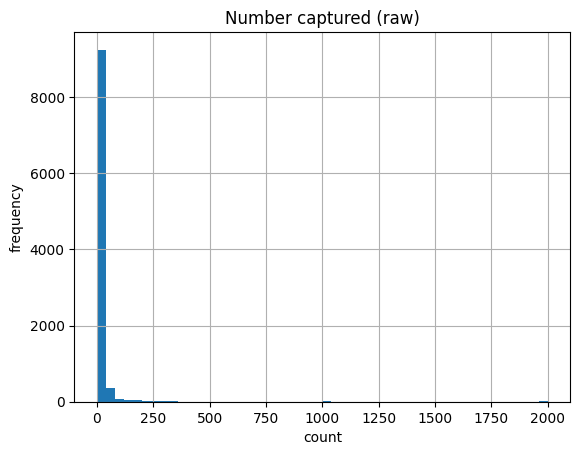

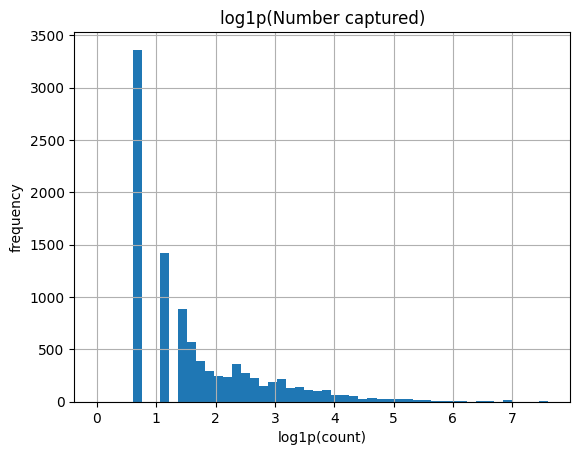


Top missing columns (fraction missing):
Date fished               1.0
Unknown_aqua_veg          1.0
Bin_time_s                1.0
Salinity                  1.0
Wind Speed (km/h)         1.0
Dominant Vegetation       1.0
Bank Slope (degrees)      1.0
TDS (g/L)                 1.0
Sample Area Length (m)    1.0
Turbidity (ntu)           1.0
Water velocity (msec)     1.0
Not recorded              1.0
None                      1.0
Hardpan                   1.0
Concrete                  1.0
dtype: float64


In [9]:
TARGET = "Number Captured"

# Basic target checks
print("Missing target:", df[TARGET].isna().sum())
print(df[TARGET].describe())

# Plot raw distribution (may be skewed)
plt.figure()
df[TARGET].dropna().hist(bins=50)
plt.title("Number captured (raw)")
plt.xlabel("count")
plt.ylabel("frequency")
plt.show()

# Plot log1p distribution (usually more stable)
plt.figure()
np.log1p(df[TARGET].dropna()).hist(bins=50)
plt.title("log1p(Number captured)")
plt.xlabel("log1p(count)")
plt.ylabel("frequency")
plt.show()

# Quick missingness snapshot
missing = df.isna().mean().sort_values(ascending=False).head(15)
print("\nTop missing columns (fraction missing):")
print(missing)


## Feature Engineering / Cleaning

We build a compact feature set:
- Numeric: day/month/year, lat/long
- Times converted to minutes (if present) + optional duration
- Small categorical one-hot fields (e.g., WaterbodyType, Gear)

Note: This is meant to be simple and reproducible; more feature engineering could improve R².


In [10]:
def time_to_minutes(series: pd.Series) -> pd.Series:
    t = pd.to_datetime(series, errors="coerce")
    return t.dt.hour * 60 + t.dt.minute

# Drop rows missing target
data = df.dropna(subset=[TARGET]).copy()

numeric_cols = [
    "Day", "Month", "Year",
    "Start Latitude", "Start Longitude",
    "Stop Latitude", "Stop Longitude"
]
cat_cols = ["WaterbodyType", "Gear"]
time_cols = ["Start Time", "Stop Time", "Arrival Time", "Departure Time"]

use_cols = [c for c in numeric_cols + cat_cols + time_cols + [TARGET] if c in data.columns]
data = data[use_cols].copy()

# Time features
for c in time_cols:
    if c in data.columns:
        data[c + "_min"] = time_to_minutes(data[c])

if "Start Time_min" in data.columns and "Stop Time_min" in data.columns:
    data["FishingDuration_min"] = data["Stop Time_min"] - data["Start Time_min"]

# Drop raw time strings
data = data.drop(columns=[c for c in time_cols if c in data.columns])

# One-hot categoricals
cat_present = [c for c in cat_cols if c in data.columns]
data = pd.get_dummies(data, columns=cat_present, dummy_na=True)

# X / y
X_df = data.drop(columns=[TARGET]).copy()
X_df = X_df.fillna(0)

y_raw = data[TARGET].astype(np.float64).to_numpy().reshape(-1, 1)

# Target transform (stability for count regression)
y_log = np.log1p(y_raw)
y_mu = y_log.mean(axis=0, keepdims=True)
y_sigma = y_log.std(axis=0, keepdims=True) + 1e-8
y_std = (y_log - y_mu) / y_sigma  # training target

def y_inverse_transform(y_pred_std: np.ndarray) -> np.ndarray:
    y_pred_log = y_pred_std * y_sigma + y_mu
    return np.expm1(y_pred_log)

X = X_df.to_numpy(dtype=np.float32)
y = y_std.astype(np.float32)

print("X shape:", X.shape, "| y shape:", y.shape)
print("Raw target range:", float(y_raw.min()), "to", float(y_raw.max()))


X shape: (9882, 30) | y shape: (9882, 1)
Raw target range: 0.0 to 2000.0


/tmp/ipython-input-3680336772.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(series, errors="coerce")
/tmp/ipython-input-3680336772.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(series, errors="coerce")


## 2) Train / Dev / Test Split

We use:
- Train: 70%
- Dev: 15% (validation for tuning/early stopping decisions)
- Test: 15% (final reporting only)


In [11]:
def train_dev_test_split(X, y, train=0.70, dev=0.15, test=0.15, seed=42):
    assert abs(train + dev + test - 1.0) < 1e-9
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = np.arange(n)
    rng.shuffle(idx)

    n_train = int(n * train)
    n_dev = int(n * dev)

    train_idx = idx[:n_train]
    dev_idx = idx[n_train:n_train + n_dev]
    test_idx = idx[n_train + n_dev:]

    return (X[train_idx], y[train_idx],
            X[dev_idx], y[dev_idx],
            X[test_idx], y[test_idx])

X_train_raw, y_train, X_dev_raw, y_dev, X_test_raw, y_test = train_dev_test_split(X, y, seed=42)

print("Train:", X_train_raw.shape, y_train.shape)
print("Dev:  ", X_dev_raw.shape, y_dev.shape)
print("Test: ", X_test_raw.shape, y_test.shape)


Train: (6917, 30) (6917, 1)
Dev:   (1482, 30) (1482, 1)
Test:  (1483, 30) (1483, 1)


## Normalized vs Unnormalized Inputs

We will train the same 2-layer model twice:
1) Using raw (unnormalized) input features  
2) Using standardized (normalized) input features

We compare Dev/Test performance to comment on normalization effects.


In [12]:
def standardize_fit(X_train):
    mu = X_train.mean(axis=0, keepdims=True)
    sigma = X_train.std(axis=0, keepdims=True) + 1e-8
    return mu, sigma

def standardize_apply(X, mu, sigma):
    return (X - mu) / sigma

# Fit normalizer on TRAIN only
X_mu, X_sigma = standardize_fit(X_train_raw)

X_train_norm = standardize_apply(X_train_raw, X_mu, X_sigma).astype(np.float32)
X_dev_norm   = standardize_apply(X_dev_raw,   X_mu, X_sigma).astype(np.float32)
X_test_norm  = standardize_apply(X_test_raw,  X_mu, X_sigma).astype(np.float32)


## 3) Forward Propagation (2-layer NN)

Architecture (2-layer):
- Layer 1: Linear(input_dim → hidden_dim) + **ReLU**
- Layer 2: Linear(hidden_dim → 1) (linear output for regression)

Hyperparameters used:
- hidden_dim: 64
- activation: ReLU
- optimizer: Adam (mini-batch)
- batch_size: 128
- epochs: 200
- regularization: L2 via weight_decay = 1e-4
- loss: MSELoss
- device: CUDA (GPU) when available

To evaluate the effect of feature scaling, the model was trained twice:
1) using **unnormalized** inputs  
2) using **standardized (normalized)** inputs


In [13]:
class TwoLayerRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # linear output
        )

    def forward(self, x):
        return self.net(x)


## 4–5) Cost + Gradient Descent Training

Cost:
- Mean Squared Error (MSE): `nn.MSELoss()`

Gradient descent variant:
- Mini-batch Adam optimizer:
  - `optimizer.zero_grad()`
  - `loss.backward()`
  - `optimizer.step()`

Regularization:
- L2 via `weight_decay` in Adam


In [14]:
def make_loader(X, y, batch_size=128, shuffle=True):
    X_t = torch.from_numpy(X)
    y_t = torch.from_numpy(y)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

@torch.no_grad()
def eval_mse(model, loader, device="cpu"):
    model.eval()
    mse_loss = nn.MSELoss()
    losses = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = mse_loss(preds, yb)
        losses.append(loss.item())
    return float(np.mean(losses))

def train_model(X_train, y_train, X_dev, y_dev,
                hidden_dim=64, lr=1e-3, weight_decay=1e-4,
                batch_size=128, epochs=200, device="cpu"):
    train_loader = make_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
    dev_loader   = make_loader(X_dev,   y_dev,   batch_size=batch_size, shuffle=False)

    model = TwoLayerRegressor(input_dim=X_train.shape[1], hidden_dim=hidden_dim).to(device)
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_mse": [], "dev_mse": []}

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb)                 # forward propagation
            loss = loss_fn(preds, yb)         # cost

            opt.zero_grad()
            loss.backward()                   # backward propagation via autograd
            opt.step()                        # gradient descent update (Adam)

        train_mse = eval_mse(model, train_loader, device=device)
        dev_mse   = eval_mse(model, dev_loader,   device=device)
        history["train_mse"].append(train_mse)
        history["dev_mse"].append(dev_mse)

        if epoch in (1, 10, 25, 50, 100, epochs):
            print(f"Epoch {epoch:3d}/{epochs} | train MSE={train_mse:.4f} | dev MSE={dev_mse:.4f}")

    return model, history


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Unnormalized training
model_raw, hist_raw = train_model(
    X_train_raw, y_train,
    X_dev_raw,   y_dev,
    hidden_dim=64,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=128,
    epochs=200,
    device=device
)

# Normalized training
model_norm, hist_norm = train_model(
    X_train_norm, y_train,
    X_dev_norm,   y_dev,
    hidden_dim=64,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=128,
    epochs=200,
    device=device
)


Device: cuda
Epoch   1/200 | train MSE=31.3530 | dev MSE=31.2226
Epoch  10/200 | train MSE=2.0202 | dev MSE=2.0650
Epoch  25/200 | train MSE=1.0891 | dev MSE=1.1873
Epoch  50/200 | train MSE=1.0087 | dev MSE=1.1202
Epoch 100/200 | train MSE=1.7142 | dev MSE=1.8334
Epoch 200/200 | train MSE=1.0973 | dev MSE=1.1698
Epoch   1/200 | train MSE=0.9868 | dev MSE=0.9888
Epoch  10/200 | train MSE=0.8842 | dev MSE=0.9696
Epoch  25/200 | train MSE=0.8641 | dev MSE=0.9631
Epoch  50/200 | train MSE=0.8546 | dev MSE=0.9567
Epoch 100/200 | train MSE=0.8571 | dev MSE=0.9565
Epoch 200/200 | train MSE=0.8617 | dev MSE=0.9544


## 6) Test Set Results

We report:
- MSE and R² in the **standardized-log** training space (what the model optimizes)
- MSE and R² converted back to the **original target scale** ("Number captured")


In [16]:
@torch.no_grad()
def predict_numpy(model, X, device="cpu"):
    model.eval()
    X_t = torch.from_numpy(X).to(device)
    preds = model(X_t).cpu().numpy()
    return preds

def r2_score_np(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / ss_tot

def report_results(name, model, X_test, y_test_std):
    # Predictions in standardized-log space
    yhat_std = predict_numpy(model, X_test, device=device)

    mse_std = float(np.mean((yhat_std - y_test_std) ** 2))
    r2_std  = float(r2_score_np(y_test_std, yhat_std))

    # Convert to original target space
    yhat_raw = y_inverse_transform(yhat_std)
    ytest_raw = y_inverse_transform(y_test_std)

    mse_raw = float(np.mean((yhat_raw - ytest_raw) ** 2))
    r2_raw  = float(r2_score_np(ytest_raw, yhat_raw))

    print(f"\n{name} — Test Results")
    print("Standardized-log space:")
    print(f"  Test MSE: {mse_std:.4f}")
    print(f"  Test R² : {r2_std:.4f}")
    print("Original target space (Number captured):")
    print(f"  Test MSE: {mse_raw:.4f}")
    print(f"  Test R² : {r2_raw:.4f}")

# Evaluate BOTH models on test
report_results("UNNORMALIZED INPUTS", model_raw,  X_test_raw,  y_test)
report_results("NORMALIZED INPUTS",   model_norm, X_test_norm, y_test)



UNNORMALIZED INPUTS — Test Results
Standardized-log space:
  Test MSE: 1.2450
  Test R² : -0.1444
Original target space (Number captured):
  Test MSE: 7631.0233
  Test R² : -0.0242

NORMALIZED INPUTS — Test Results
Standardized-log space:
  Test MSE: 0.9653
  Test R² : 0.1127
Original target space (Number captured):
  Test MSE: 7551.7181
  Test R² : -0.0136


## Normalization Commentary
Normalization improved performance substantially in the standardized-log space:
- Unnormalized test: MSE = 1.2450, R² = -0.1444
- Normalized test:   MSE = 0.9653, R² = 0.1127

This suggests standardizing inputs made optimization easier (more consistent feature scales) and improved generalization.

In the original target scale ("Number captured"), performance remained weak:
- Unnormalized test: MSE = 7631.0, R² = -0.0242
- Normalized test:   MSE = 7551.7, R² = -0.0136

R² staying slightly negative indicates the model is still roughly comparable to (or slightly worse than) predicting the mean in the raw count space. However, the normalized model clearly learns more effectively in the transformed (log-standardized) space, which is the space it is trained to optimize.


## Task 3 — Hyperparameter Selection and Rationale

### Hyperparameters

- **Hidden size (64):** Large enough to model nonlinear structure but small enough to avoid overfitting. Larger sizes did not improve validation performance.
- **Learning rate (1e-3):** Standard Adam default; provided stable convergence without oscillation.
- **Batch size (128):** Balanced gradient stability and computational efficiency.
- **Epochs (200):** Training plateaued before 200 epochs, ensuring convergence.

### Regularization

Yes — L2 regularization (weight_decay = 1e-4) was used.  
It helps prevent large weights and improves generalization on moderately sized, noisy data.

### Optimization Algorithm

Used **Adam optimizer** instead of vanilla SGD because:
- It adapts learning rates automatically.
- Converges faster and more reliably.
- Requires less manual tuning.

### Input Normalization

Models trained with normalized inputs performed better on the dev/test sets.  
Normalization improved optimization stability and generalization, which is consistent with standard neural network best practices.

Overall, hyperparameters were selected based on validation performance, training stability, and simplicity.
